***Note: this is the MWC.ipynb notebook.***
 The PDF version "The Monod-Wyman-Changeux model"
is available [here](modulatedCooperative.pdf).***

*** Note: incomplete ***

# Introduction
"For many enzymes, the reaction velocity is not a simple hyperbolic curve, as predicted
by the Michaelis–Menten model, but often has a sigmoidal character. This can result from cooperative effects, in which the enzyme can bind more than one substrate
molecule but the binding of one substrate molecule affects the binding of subsequent
ones" <cite data-cite="KeeSne09">(Keener and Sneyd, 2009)</cite>, Section 1.4.4.

This note gives a bond graph <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite> interpretation of such cooperativity and uses the iterative properties of [BondGraphTools](https://pypi.org/project/BondGraphTools/) <cite data-cite="CudGawPanCra19X">(Cudmore et. al., 2019)</cite> to build high-order cooperative systems. These systems are simulated to give steady-state behavior as the order of cooperativity increases.



## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports

import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Modular bond graphs
import modularBondGraph as mbg

## Stoichiometry to BG
import stoichBondGraph as stbg

## Data structure copy
import copy

## Set quiet=False for verbose output
quiet = True

# Enzyme-catalysed reaction
The basic enzyme-catalysed reaction is given in this section. It is the basic building block of cooperative enzyme-catalysed reactions
More details are given by <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite>.


In [2]:
bgt.version

'0.3.7'

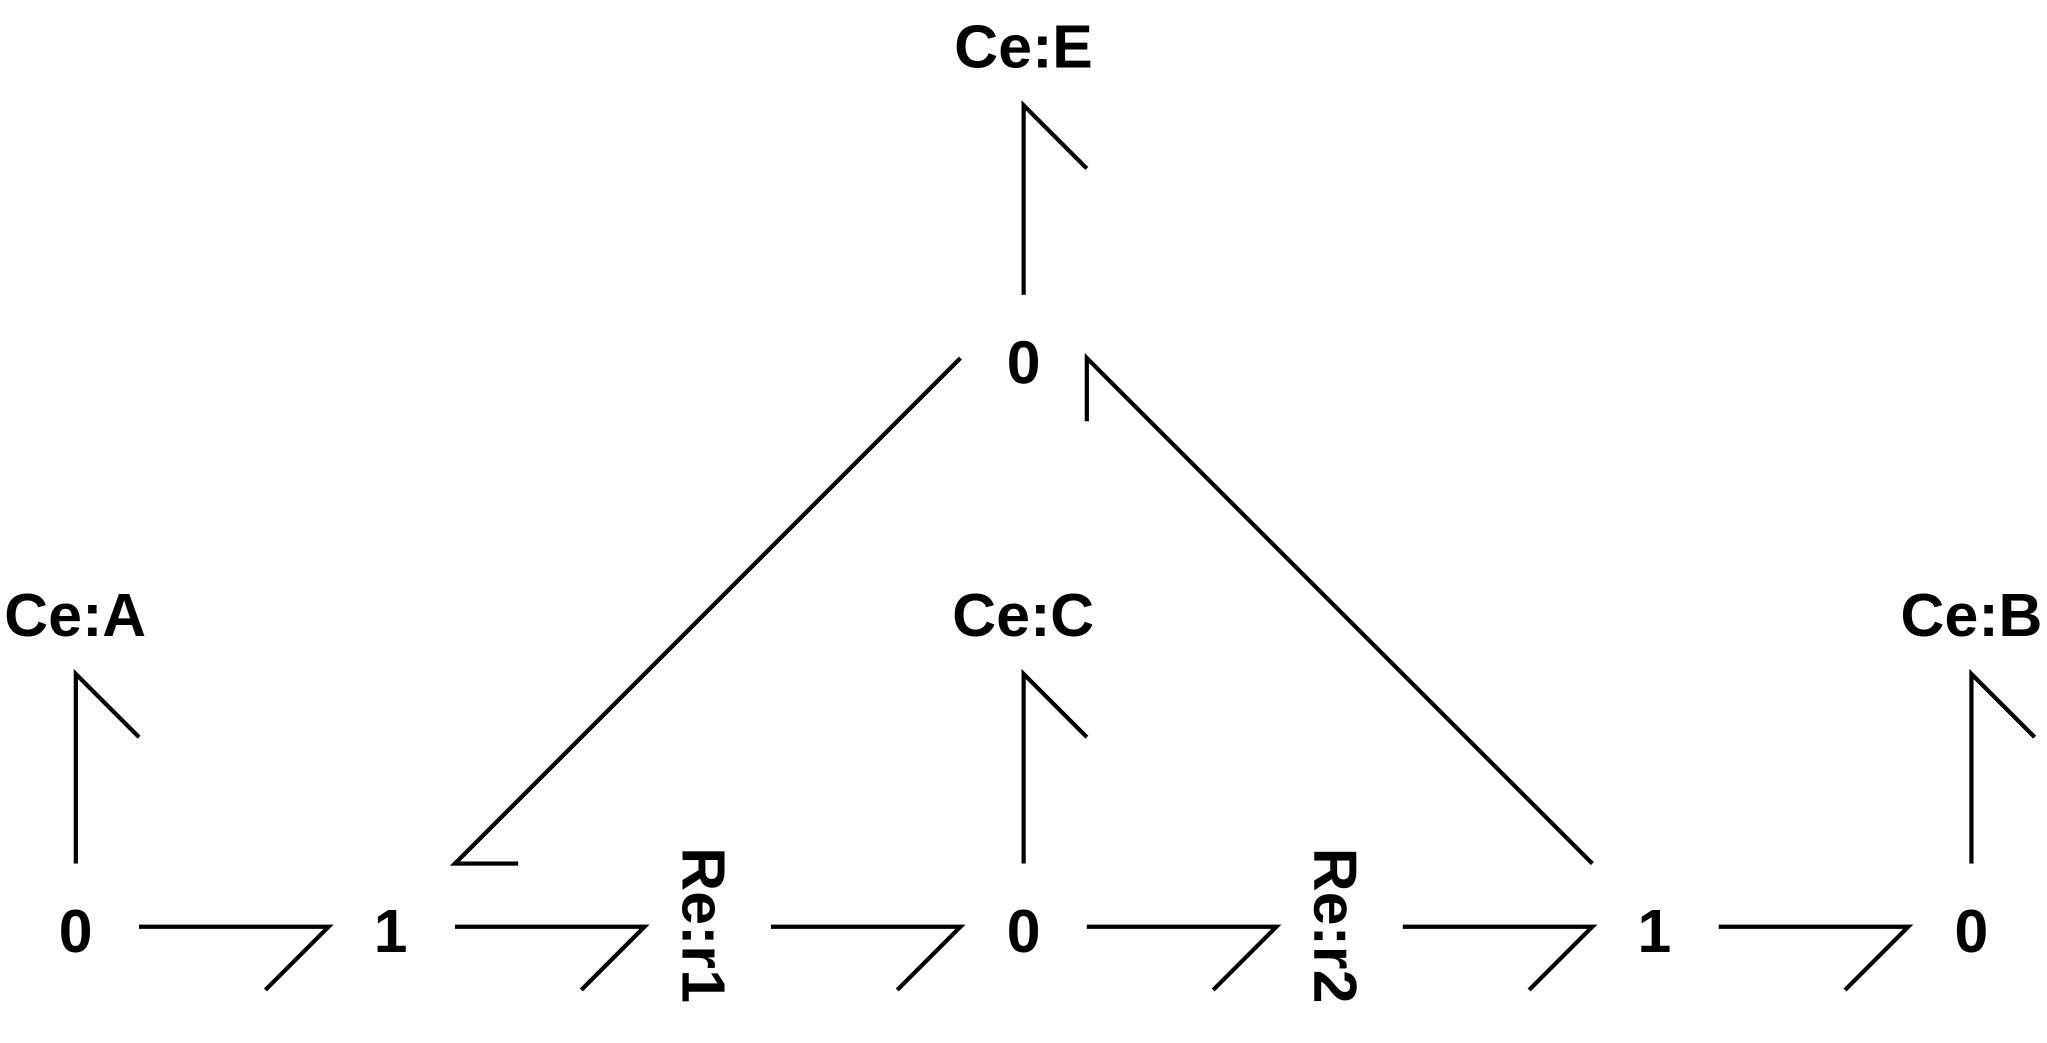

In [3]:
## Enzyme-catalysed reaction
sbg.model('RE_abg.svg')
import RE_abg
disp.SVG('RE_abg.svg')

In [4]:
s = st.stoich(RE_abg.model(),quiet=quiet)
disp.Latex(st.sprintrl(s,chemformula=True))

<IPython.core.display.Latex object>

# Cooperative enzyme-catalysed reaction

<cite data-cite="KeeSne09">(Keener and Sneyd, 2009)</cite>, Section 1.4.4, discusses cooperativity. This section gives a bond graph interpretation. This is done in two ways:

1. As a graphical representation of a two-stage cooperative enzyme-catalysed reaction.
2. As a generic representation of an N-stage cooperative enzyme-catalysed reaction using  [bond-graph tools](https://pypi.org/project/BondGraphTools/)

## Two-stage cooperative enzyme-catalysed reaction (N=2) <a id='coop2'></a>


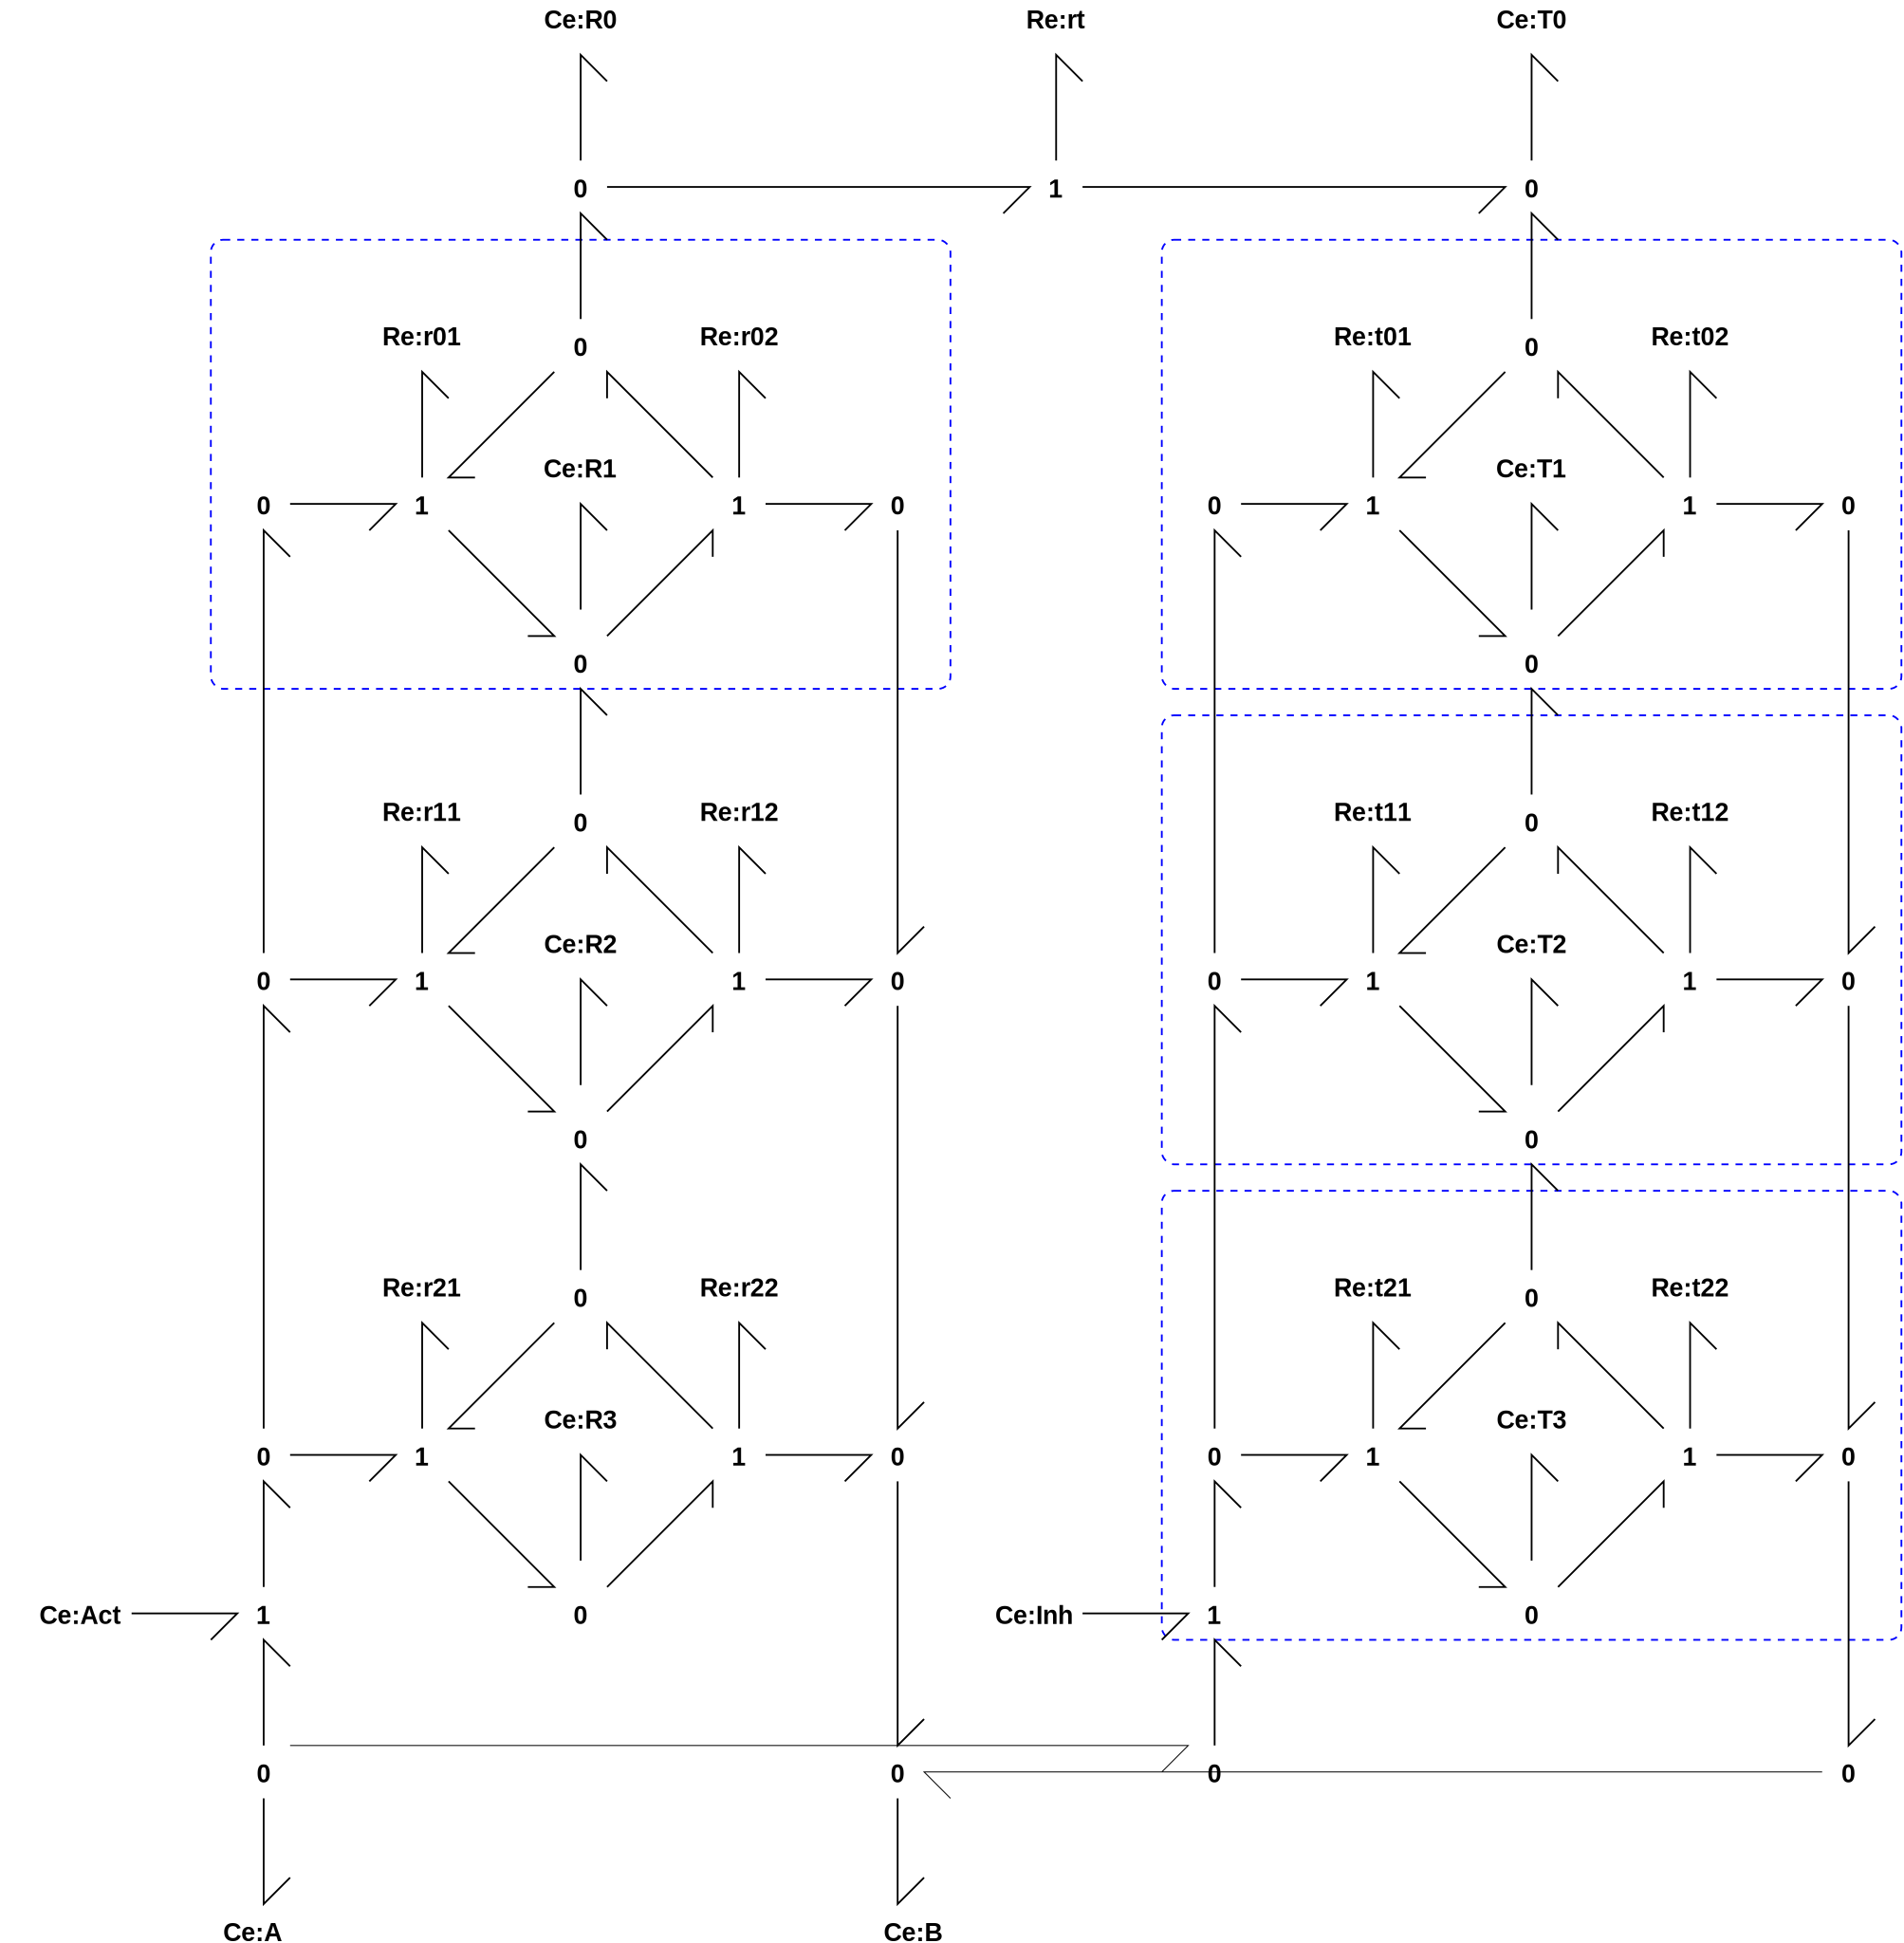

In [5]:
## MWC model
sbg.model('MWC_abg.svg',quiet=quiet)
import MWC_abg
disp.SVG('MWC_abg.svg')

In [6]:
ss = st.stoich(MWC_abg.model(),quiet=quiet)
ssc = st.statify(ss,chemostats=['A','Br','Bt','Act','Inh'])
disp.Latex(st.sprintrl(ss,chemformula=True))


Chemostat Br is not a model species
Chemostat Bt is not a model species


<IPython.core.display.Latex object>

## Create cooperative enzyme-catalysed reaction of any degree N
The following code builds an N-stage cooperative enzyme-catalysed reaction using  [bond-graph tools](https://pypi.org/project/BondGraphTools/).

1. N+1 instances of the basic enzyme-catalysed reaction are created and the enzyme and complex renamed.
2. The substrate A, product B  and enzymes E1-EN are unified.

In [7]:
## Create cooperative enzyme-catalysed reaction of any degree N
def makeCoop(N=3,R='R',quiet=True):
    r = R.lower()
    Coop = bgt.new(name='Coop')
    for i in range(N+1):
        RE = RE_abg.model()
        RE.name = 'RE'+str(i)
        mbg.rename(RE,{
                    'E':R+str(i), 
                    'C':R+str(i+1),
                    'r1':r+str(i)+'1',
                    'r2':r+str(i)+'2'
                    },
                   quiet=quiet)
        Coop.add(RE)

    ## Unify common components
    unified = ['A','B']
    for i in range(N): 
        Ri = R+str(i+1)
        unified.append(Ri)
    print('unified =',unified)
    mbg.unify(Coop,unified,quiet=quiet)

        
    ## Stoichiometry
    chemostats = ['A','B']
    s = st.stoich(Coop,quiet=quiet)
    sc = st.statify(s,chemostats=chemostats)
    if not quiet:
        print(st.sprint(sc,'species'))
        print(st.sprint(sc,'reaction'))
        
    ## Regenerate flat Coop BG from stoichiometry
    s['name'] = R+'_abg'
    stbg.model(s)
    
    return s,sc

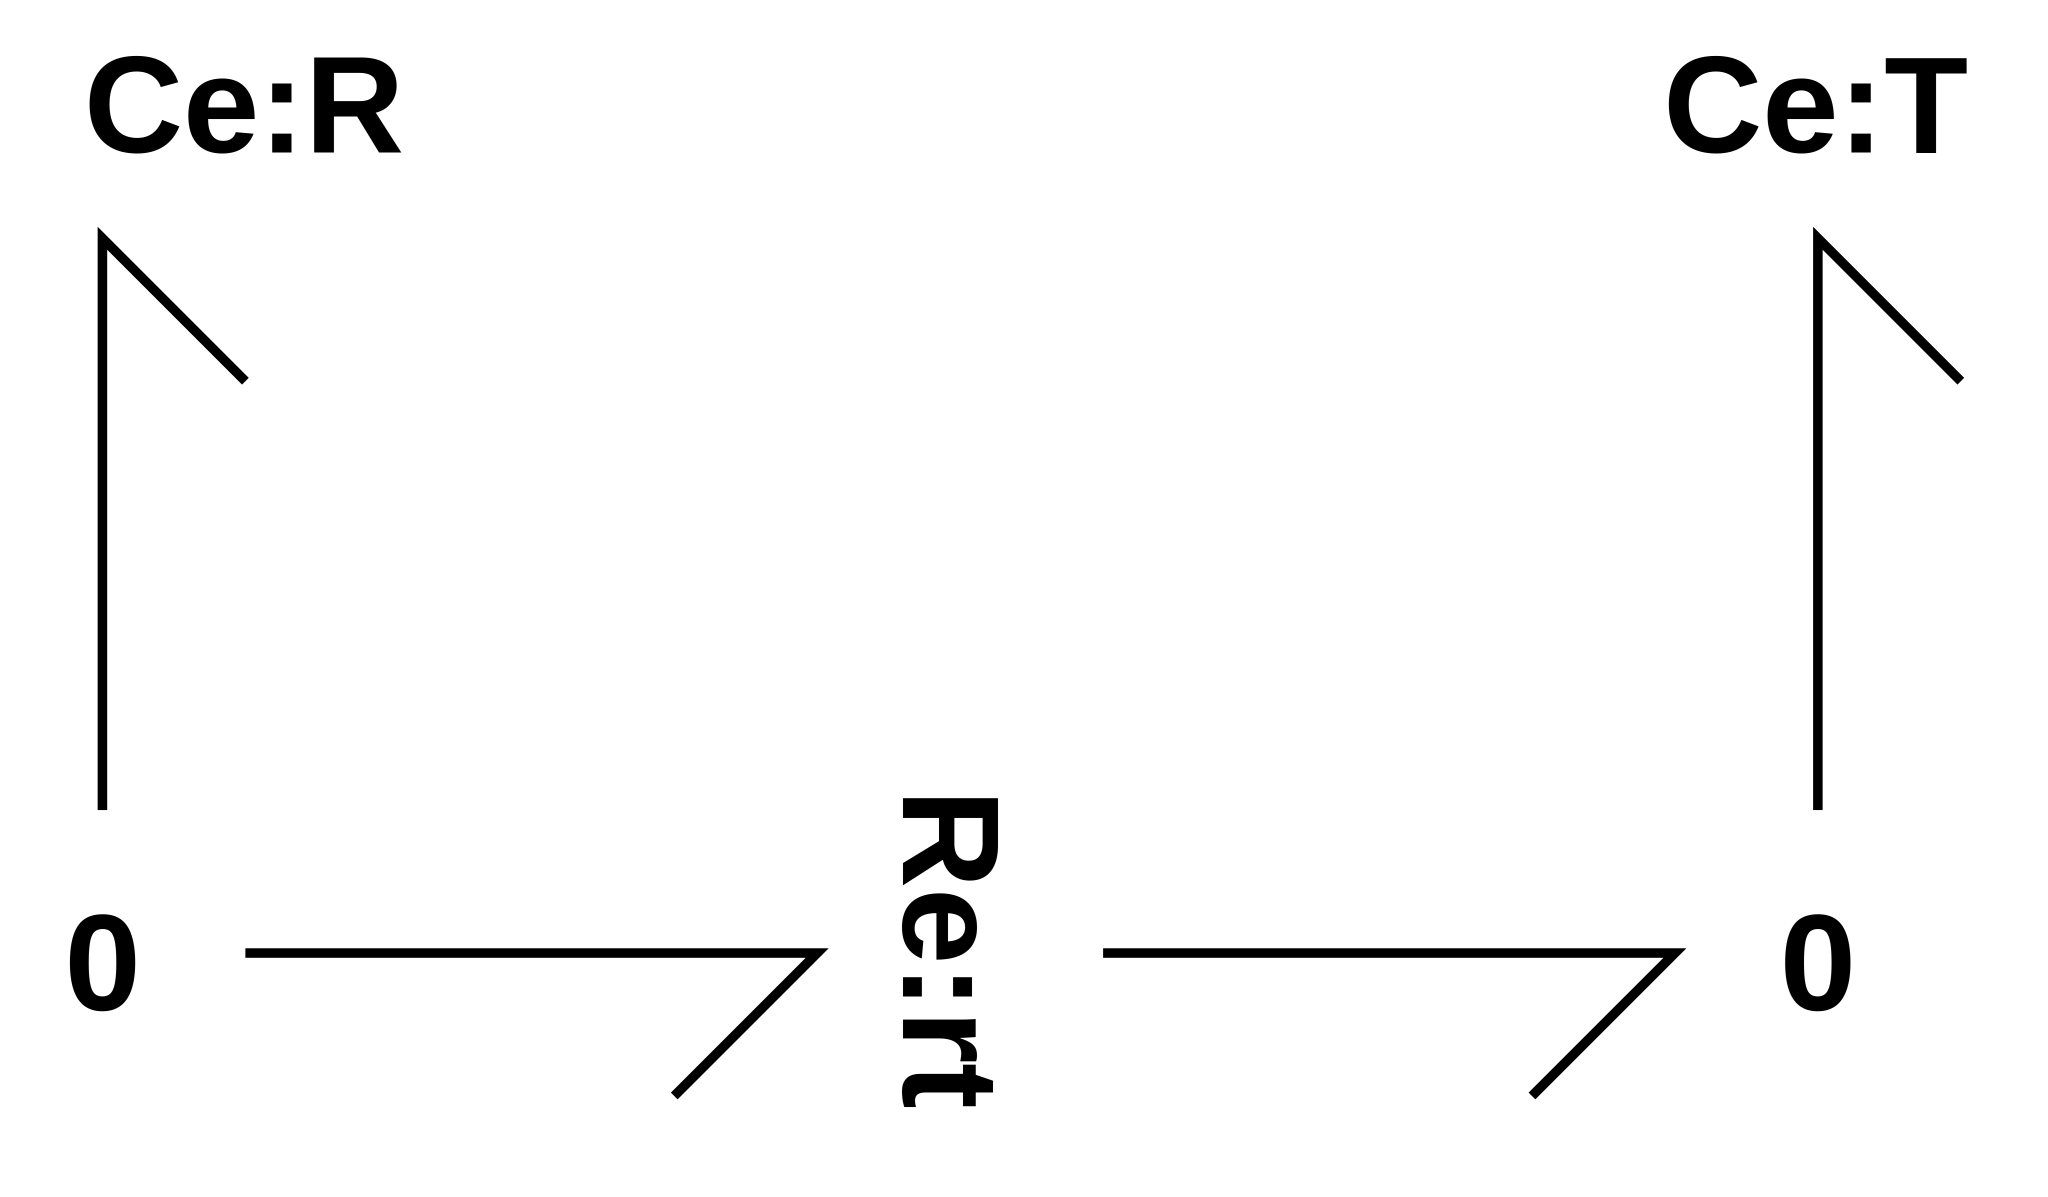

In [8]:
## Connecting system
sbg.model('RT_abg.svg',quiet=quiet)
import RT_abg
disp.SVG('RT_abg.svg')

In [9]:
srt = st.stoich(RT_abg.model(),quiet=quiet)
srtc = st.statify(srt,chemostats=['R0','T0'])
disp.Latex(st.sprintrl(srt,chemformula=True))


Chemostat R0 is not a model species
Chemostat T0 is not a model species


<IPython.core.display.Latex object>

In [10]:
## Create Monod-Wyman-Changeux model
def makeMWC(N=3,quiet=False):
    MWC = bgt.new(name='MWC')   
    sR,sRc = makeCoop(N=N,R='R',quiet=quiet)
    sT,sRT = makeCoop(N=N,R='T',quiet=quiet)
    import R_abg
    import T_abg
    import RT_abg
    
    MWC.add(R_abg.model(),T_abg.model(),RT_abg.model())
    
#     ## Unify common components
#     unified = ['A','B','R0','T0']
    
#    MWC.add(R_abg.model(),T_abg.model())
    
    ## Unify common components
    unified = ['A','B','R','T']
    
    mbg.unify(MWC,unified,quiet=False)
    
    ## Stoichiometry
    chemostats = ['A','B']
    s = st.stoich(MWC,quiet=quiet)
    sc = st.statify(s,chemostats=chemostats)
    if not quiet:
        print(st.sprint(sc,'species'))
        print(st.sprint(sc,'reaction'))
    
    return s,sc,MWC

### Generate equations for $N=2$
Note that these equations are identical to those of the explicit bondgraph.

In [11]:
### Generate equations for N=2
s,sc,MWC = makeMWC(N=2,quiet=quiet)
disp.Latex(st.sprintrl(s,chemformula=True))

unified = ['A', 'B', 'R1', 'R2']
unified = ['A', 'B', 'T1', 'T2']
Unifying components in: MWC
Creating: Ce:A and 0:A_jun in MWC
Creating: Ce:B and 0:B_jun in MWC
Creating: Ce:R and 0:R_jun in MWC
Creating: Ce:T and 0:T_jun in MWC
Exposing: Ce:A in R_abg and connecting to 0:A_jun
Exposing: Ce:B in R_abg and connecting to 0:B_jun
Exposing: Ce:A in T_abg and connecting to 0:A_jun
Exposing: Ce:B in T_abg and connecting to 0:B_jun
Exposing: Ce:R in RT and connecting to 0:R_jun
Exposing: Ce:T in RT and connecting to 0:T_jun


<IPython.core.display.Latex object>

### Generate pathway equations for $N=2$
Pathways are generated using the approach of <cite data-cite="GawCra17">Gawthrop and Crampin (2014)</cite>.

In [12]:
sp = st.path(s,sc)
print(st.sprintp(sc))
disp.Latex(st.sprintrl(sp))

6 pathways
0:  + r01 + r02
1:  + r11 + r12
2:  + r21 + r22
3:  + t01 + t02
4:  + t11 + t12
5:  + t21 + t22



<IPython.core.display.Latex object>

## Steady-state properties

The steady state properties are investigated using dynamic simulation where slowly varing exogenous quantities are used to induce quasi-steady-state behaviour. In each case, the variable is at a constant value to start with followed by a slowly increasing ramp. The response after the initial reponse is plotted to remove artefacts due to the initial transient.

All parameters are unity except for $K_B=0.01$ (to approximate an irreversible reaction) and initial states are chosen so that the total enzyme is $e_0=1$.

### Set up some parameters for simulation

In [13]:
## Set up some parameters for simulation
def setParameter(ss,N,K_R0,K_T0,X_Act,X_Inh):
    
    e0 = 1/2
        
    ## Set up the non-unit parameters and states
    parameter = {}

    
    K_i = 1/(K_R0**(N+1))
    for i in range(N+2):
        Ki = 'K_R'+str(i)
        #print('Setting:', Ki)
        parameter[Ki] = K_i
        K_i *= K_R0
    
    K_i = 1/(K_T0**(N+1))
    if 'T0' in s['species']: 
        for i in range(N+2):
            Ki = 'K_T'+str(i)
            #print('Setting:', Ki)
            parameter[Ki] = K_i
            K_i *= K_T0

    ## Set product constant to a small value
    ## to make the RCR approximately irreversible
    K_B = 1e-10
    parameter['K_B'] = K_B
#     parameter['K_Br'] = K_B
#     parameter['K_Bt'] = K_B
    
#     parameter['K_R00'] = parameter['K_R0'] 
#     parameter['K_T00'] = parameter['K_T0'] 
#    parameter['K_Inh'] = 100
    
    ## States
    X0 = np.ones(ss['n_X'])
    X0[ss['spec_index']['Act']] = X_Act
    X0[ss['spec_index']['Inh']] = X_Inh
    
    ## Set total enzyme to e0
    for i in range(N+2):
        Ri = 'R'+str(i)
        X0[ss['spec_index'][Ri]] = (e0/(N+2))  
        
    if 'T0' in s['species']:  
        for i in range(N+2):
            Ti = 'T'+str(i)
            X0[ss['spec_index'][Ti]] = (e0/(N+2)) 
    
    return parameter,X0

### Vary substrate concentration  $x_A$ for various $K_{T0}$

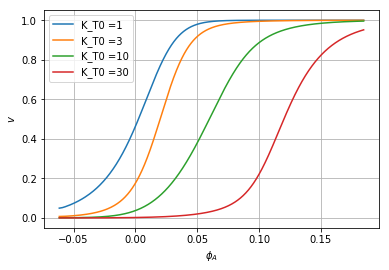

In [14]:
## Simulation
## Vary x_A

##Time
quiet = True
t_max = int(1e5)
t = np.linspace(0,t_max,100000)
t_0 = 100
t_1 = t_max-t_0
i_max = len(t)
i_0 = int(i_max*t_0/t_max)
i_1 = i_max-i_0

## Chemostats: vary x_A
x_max = 1e3
x_min = 1e-1
    
A_chemo = '{3} + ({0}-{3})*np.heaviside(t-{1},1)*((t-{1})/{2})'.format(x_max,t_0,t_1,x_min)
X_chemo =  {'A':A_chemo}

K_R0 = 1
K_T0 = 1


for K_T0 in [1,3,10,30]:
    N = 2

    X_Act = K_T0
    X_Inh = 1
    
    parameter,X0 = setParameter(ss,N,K_R0,K_T0,X_Act,X_Inh)

    dat = st.sim(ss,sc=ssc,t=t,parameter=parameter,X0=X0,X_chemo=X_chemo,quiet=quiet)
    phi_A = dat['phi'][:,ss['spec_index']['A']]
    dX = ss['N']@(dat['V'].T)
    dX_B = dX[ss['spec_index']['B'],:]
    V_B = dX_B[-i_1:]
    
    ## Plot flow v. x_A  
    grey = '0.8'
    plt.plot(phi_A[-i_1:],V_B,label = 'K_T0 ='+str(K_T0)) 
plt.grid()
plt.legend()
#plt.ylim((0,e0))
#plt.xlim((0,x_max))
#plt.legend(['N=0 (theory)']+['N='+str(i) for i in NN]+['MWC'])
plt.xlabel('$\phi_A$')
plt.ylabel('$v$')
plt.show()

